In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customeragreement/Dialogs.txt
/kaggle/input/customeragreement/TestData.csv
/kaggle/input/customeragreement/TrainingData.csv


There is a regression task. The input data is lines from dialogs between customer and sell manager. The target variable is the ratio of the customer agreement.

The current task is based on the following rules:
1. Customer initiate the dialog
2. Predictor analyze thee blocks of text: customer init messages; following sell manager answer (or, optionally, questions); following customer messages
3. Predictor also analyze the previous measure of customer agreement

Customer init messages contains part of dialog context, including reactions 

In [18]:
df_train = pd.read_csv('/kaggle/input/customeragreement/TrainingData.csv')
df_train.head(10)

,PrevBaro,CustomerInitMessage,SellerAnswer,CustomerFollowingMessage,Agreement,TemperamentCholeric,TemperamentPhlegmatic,TemperamentSanguine,TemperamentMelancholic
0,0.50,"Здравствуйте, Геннадий!",Добрый день! Чем я могу вам помочь?,Меня интересует оптовая партия стройматериалов,0.75,0.75,0.25,0.25,0.25
1,0.75,Меня интересует оптовая партия стройматериалов,"Думаю, мы сможем вам помочь. Какие именно стро...","Партия сосновых досок, 5000 кубометров",0.75,0.75,0.50,0.25,0.25
2,0.75,"Партия сосновых досок, 5000 кубометров.",Мы готовы поставить вам данную партию за 50 00...,"Для меня это слишком высокая цена, я хотел бы ...",0.25,0.50,1.00,0.50,0.15
3,0.25,"Для меня это слишком высокая цена, я хотел бы ...","К сожалению, наша корпоративная политика не пр...","Тогда я не буду ничего покупать, до свидания",0.00,0.25,1.00,0.15,0.10
4,0.25,"Для меня это слишком высокая цена, я хотел бы ...",Мы готовы предоставить скидку 15% на данный то...,"Спасибо, я куплю товар.",1.00,0.75,1.00,0.25,0.50
5,0.50,"Здравствуйте, Алексей!",Добрый день! Чем я могу вам помочь?,Я хотел бы выбрать подарок на День рождения че...,0.50,0.50,0.75,1.00,0.50
6,0.50,Я хотел бы выбрать подарок на День рождения че...,Какие именно подарки вас интересуют?,Я пока не определился. Чтобы вы порекомендавал...,0.25,0.25,1.00,1.00,0.75
7,0.25,Я пока не определился. Чтобы вы порекомендавал...,Мы можем предложить подарочные наборы в сегмен...,"Да, давайте посмотрим",0.50,0.50,0.75,0.75,0.75
8,0.50,"Да, давайте посмотрим","Вот список подходящих подарочных наборов, расс...",Расскажите про набор номер 4,0.75,0.50,1.00,0.75,0.25
9,0.75,Расскажите про набор номер 4,Набор номер 4 включает в себя набор мяса дичи....,"Да, я готов купить данный набор.",1.00,0.75,0.75,0.50,0.25


In [9]:
df_test = pd.read_csv('/kaggle/input/customeragreement/TestData.csv')
df_test.head()

,PrevBaro,CustomerInitMessage,SellerAnswer,CustomerFollowingMessage
0,0,"Здравствуйте, Владигор!",Добрый день! Чем я могу вам помочь?,Меня интересует оптовая партия бипков


First we need to preprocess the training data.

In [10]:
!pip3 install git+https://github.com/kmike/pymorphy2

  Cloning https://github.com/kmike/pymorphy2 to /tmp/pip-req-build-3w4ot8mc
  Running command git clone -q https://github.com/kmike/pymorphy2 /tmp/pip-req-build-3w4ot8mc
     |████████████████████████████████| 8.2 MB 833 kB/s eta 0:00:01
  Created wheel for pymorphy2: filename=pymorphy2-0.9.1-py3-none-any.whl size=55246 sha256=84cd68ce711ef28330a6dd0ba91ef8770c3ae666ec9fd421140701a9d4fa5bde
  Stored in directory: /tmp/pip-ephem-wheel-cache-1cikza15/wheels/a1/2d/c8/b43cb8689a03feb771826c254864c7a4119a50db9759df903d
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=47004a22302f7544e4e5607b698d10988f574fd8c8ee368147702c1c57f4069d
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built pymorphy2 docopt


In [11]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

import nltk
import pymorphy2
nltk.download('stopwords')

import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords


stopwords_ru = stopwords.words("russian")

class Lemmatizer(BaseEstimator):

    patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
    morph = MorphAnalyzer()
    
    def fit(self, X, y):
        if isinstance(X, np.ndarray):
            # Check that X and y have correct shape
            X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        return self
    
    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = check_array(X, accept_sparse=True)
            return X
        return X.apply(self.lemmatize)
    
#     def fit_transform(self, X, y):
#         return self.fit(X, y).transform(X)
            
    def lemmatize(self, line):
        data = re.sub(self.patterns, ' ', line)
        tokens = []
        for token in data.split():
            if token and token not in stopwords_ru:
                token = token.strip()
                token = self.morph.normal_forms(token)[0]
                tokens.append(token)
        return " ".join(token for token in tokens)
    

df_train = pd.read_csv('/kaggle/input/customeragreement/TrainingData.csv')
lemmatizer = Lemmatizer()
df_train['CustomerInitMessage'] = lemmatizer.transform(df_train['CustomerInitMessage'])
df_train['SellerAnswer'] = lemmatizer.transform(df_train['SellerAnswer'])
df_train['CustomerFollowingMessage'] = lemmatizer.transform(df_train['CustomerFollowingMessage'])
df_train.head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,PrevBaro,CustomerInitMessage,SellerAnswer,CustomerFollowingMessage,Agreement,TemperamentCholeric,TemperamentPhlegmatic,TemperamentSanguine,TemperamentMelancholic
0,0.50,здравствуйте геннадий,добрый день чем мочь помочь,я интересовать оптовый партия стройматериал,0.75,0.75,0.25,0.25,0.25
1,0.75,я интересовать оптовый партия стройматериал,думать смочь помочь какой именно стройматериал...,партия сосновый доска кубометр,0.75,0.75,0.50,0.25,0.25
2,0.75,партия сосновый доска кубометр,мы готовый поставить данный партия вы устраива...,для это слишком высокий цена хотеть получить с...,0.25,0.50,1.00,0.50,0.15
3,0.25,для это слишком высокий цена хотеть получить с...,к сожаление наш корпоративный политика предусм...,тогда быть покупать свидание,0.00,0.25,1.00,0.15,0.10
4,0.25,для это слишком высокий цена хотеть получить с...,мы готовый предоставить скидка данный товар,спасибо купить товар,1.00,0.75,1.00,0.25,0.50


In [12]:
# from sklearn.utils.estimator_checks import check_estimator
# # check_estimator(Lemmatizer())
# print(Lemmatizer().transform(df_train['CustomerInitMessage']))

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer

Y_train = df_train['Agreement']
X_train = df_train[['PrevBaro', 'CustomerInitMessage', 'SellerAnswer', 'CustomerFollowingMessage']]

tfidf = TfidfVectorizer(stop_words=stopwords_ru, ngram_range=(1,3), max_features=50000)

# create shared vocabulary
def concat_cols(df):
    assert len(df.columns) >= 2
    res = df.iloc[:, 0].astype('str')
    for key in df.columns[1:]:
       res = res + ' ' + df[key]
    return res

vocabulary = (tfidf
            .fit(concat_cols(df_train[['CustomerInitMessage', 'SellerAnswer', 'CustomerFollowingMessage']]))
            .vocabulary_)

tfidf = TfidfVectorizer(stop_words=stopwords_ru, ngram_range=(1,3), max_features=50000, vocabulary=vocabulary)

# TODO - fix the Lemmatizer to make it work as good sklearn transformer
# colimn_trans_1 = ColumnTransformer(
#      [('init_message_lemmatizer', Lemmatizer(), 'CustomerInitMessage'),
#      ('seller_answer_lemmatizer', Lemmatizer(), 'SellerAnswer'),
#      ('following_message_lemmatizer', Lemmatizer(), 'CustomerFollowingMessage')],
#      remainder='passthrough')

column_trans_2 = ColumnTransformer(
     [('init_message_tfidf', tfidf, 'CustomerInitMessage'),
     ('answer_tfidf', tfidf, 'SellerAnswer'),
     ('following_message_tfidf', tfidf, 'CustomerFollowingMessage')],
     remainder='passthrough')

text_pipe_rfr = make_pipeline(column_trans_2, 
RandomForestRegressor(n_jobs=-1, random_state=7))

text_pipe_rfr.fit(X_train, Y_train)
# print(text_pipe_rfr.score(X_train, Y_train))


param_grid_rfr = {'randomforestregressor__max_depth': range(2,11),
                  'randomforestregressor__n_estimators': range(50, 400, 50),
                  'randomforestregressor__criterion': ['mse', 'mae']}
grid_logit = GridSearchCV(text_pipe_rfr, param_grid_rfr, cv=3, n_jobs=-1, verbose=True)

grid_logit.fit(X_train, Y_train)
grid_logit.best_params_, grid_logit.best_score_

Fitting 3 folds for each of 126 candidates, totalling 378 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 378 out of 378 | elapsed:  6.5min finished


({'randomforestregressor__criterion': 'mse',
  'randomforestregressor__max_depth': 8,
  'randomforestregressor__n_estimators': 200},
 0.32944402442452153)

In [14]:
def lem_features(data, features):
    lemmatizer = Lemmatizer()
    for feature in features:
        data[feature] = lemmatizer.transform(data[feature])

features = ['CustomerInitMessage', 'SellerAnswer', 'CustomerFollowingMessage']
Y_train = df_train['Agreement']
X_train = df_train[['PrevBaro', 'CustomerInitMessage', 'SellerAnswer', 'CustomerFollowingMessage']]

X_test = df_test[['PrevBaro', 'CustomerInitMessage', 'SellerAnswer', 'CustomerFollowingMessage']]

text_pipe_rfr = make_pipeline(column_trans_2, 
RandomForestRegressor(n_jobs=-1, random_state=7, max_depth=10, max_features='auto', n_estimators=250, criterion='mse'))

text_pipe_rfr.fit(X_train, Y_train)
X_test['PrevBaro'] = 0.5
X_test['CustomerInitMessage'] = 'Добрый день, Владигор!'
X_test['SellerAnswer'] = 'Добрый день! Чем я могу вам помочь?'
X_test['CustomerFollowingMessage'] = 'Я хотел бы купить набор в подарок другу, но не могу определиться с выбором.'
lem_features(X_test, features)
X_test['PrevBaro'] = text_pipe_rfr.predict(X_test)
print(X_test['PrevBaro'])
X_test['CustomerInitMessage'] = 'Я хотел бы купить набор в подарок другу, но не могу определиться с выбором.'
X_test['SellerAnswer'] = 'Чем именно увлекается ваш друг?'
X_test['CustomerFollowingMessage'] = 'Мой друг увлекается кулинарией'
lem_features(X_test, features)
X_test['PrevBaro'] = text_pipe_rfr.predict(X_test)
print(X_test['PrevBaro'])
X_test['CustomerInitMessage'] = 'Мой друг увлекается кулинарией'
X_test['SellerAnswer'] = 'Мы можем предложить следущие кулинарные подарочные наборы.'
X_test['CustomerFollowingMessage'] = 'Расскажите подробнее про набор номер 7'
lem_features(X_test, features)
X_test['PrevBaro'] = text_pipe_rfr.predict(X_test)
print(X_test['PrevBaro'])
X_test['CustomerInitMessage'] = 'Расскажите подробнее про набор номер 7'
X_test['SellerAnswer'] = 'Данный набор имеет следующие преимущества и подходит для следующих задач'
X_test['CustomerFollowingMessage'] = 'Набор номер 7 слишком дорогой, я хотел бы посмотреть другой набор'
lem_features(X_test, features)
X_test['PrevBaro'] = text_pipe_rfr.predict(X_test)
print(X_test['PrevBaro'])
X_test['CustomerInitMessage'] = 'Набор номер 7 слишком дорогой, я хотел бы посмотреть другой набор'
X_test['SellerAnswer'] = 'Могу предложить вам набор номер 4. Он включает меньше элементов, но дешевле'
X_test['CustomerFollowingMessage'] = 'Спасибо, я возьму набор номер 4.'
lem_features(X_test, features)
print(text_pipe_rfr.predict(X_test))

0    0.455175
Name: PrevBaro, dtype: float64
0    0.616704
Name: PrevBaro, dtype: float64
0    0.960789
Name: PrevBaro, dtype: float64
0    0.5469
Name: PrevBaro, dtype: float64
[0.90829416]


In [15]:
# save the model to the file
import pickle

filename = "baro_predictor"
pickle.dump(text_pipe_rfr, open(filename, 'wb'))

# Another model is designed to predict the customer temperament.

First we need to check the correlations between temperament values in training data

<AxesSubplot:>

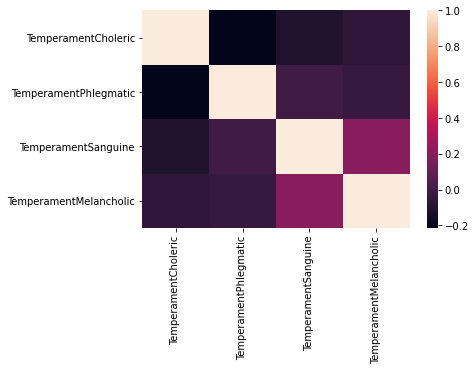

In [16]:
import seaborn as sns

corr_matrix = df_train[['TemperamentCholeric', 'TemperamentPhlegmatic', 'TemperamentSanguine', 'TemperamentMelancholic']].corr()
sns.heatmap(corr_matrix)

In [19]:
Y_train = df_train[['TemperamentCholeric', 'TemperamentPhlegmatic', 'TemperamentSanguine', 'TemperamentMelancholic']]
X_train = df_train[['CustomerInitMessage', 'SellerAnswer', 'CustomerFollowingMessage']]

text_pipe_rfr.fit(X_train, Y_train)
# print(text_pipe_rfr.score(X_train, Y_train))


param_grid_rfr = {'randomforestregressor__max_depth': range(2,11),
                  'randomforestregressor__n_estimators': range(50, 400, 50),
                  'randomforestregressor__criterion': ['mse', 'mae']}
grid_logit = GridSearchCV(text_pipe_rfr, param_grid_rfr, cv=3, n_jobs=-1, verbose=True)

grid_logit.fit(X_train, Y_train)
grid_logit.best_params_, grid_logit.best_score_

Fitting 3 folds for each of 126 candidates, totalling 378 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 378 out of 378 | elapsed:  7.4min finished


({'randomforestregressor__criterion': 'mse',
  'randomforestregressor__max_depth': 2,
  'randomforestregressor__n_estimators': 250},
 -0.58722761138814)

In [20]:
text_pipe_rfr = make_pipeline(column_trans_2, 
RandomForestRegressor(n_jobs=-1, random_state=7, max_depth=10, max_features='auto', n_estimators=250, criterion='mse'))

text_pipe_rfr.fit(X_train, Y_train)
X_test['CustomerInitMessage'] = 'Добрый день, Владигор!'
X_test['SellerAnswer'] = 'Добрый день! Чем я могу вам помочь?'
X_test['CustomerFollowingMessage'] = 'Я хотел бы купить набор в подарок другу, но не могу определиться с выбором.'
lem_features(X_test, features)
print(text_pipe_rfr.predict(X_test))
X_test['CustomerInitMessage'] = 'Я хотел бы купить набор в подарок другу, но не могу определиться с выбором.'
X_test['SellerAnswer'] = 'Чем именно увлекается ваш друг?'
X_test['CustomerFollowingMessage'] = 'Мой друг увлекается кулинарией'
lem_features(X_test, features)
print(text_pipe_rfr.predict(X_test))
X_test['CustomerInitMessage'] = 'Мой друг увлекается кулинарией'
X_test['SellerAnswer'] = 'Мы можем предложить следущие кулинарные подарочные наборы.'
X_test['CustomerFollowingMessage'] = 'Расскажите подробнее про набор номер 7'
lem_features(X_test, features)
print(text_pipe_rfr.predict(X_test))
X_test['CustomerInitMessage'] = 'Расскажите подробнее про набор номер 7'
X_test['SellerAnswer'] = 'Данный набор имеет следующие преимущества и подходит для следующих задач'
X_test['CustomerFollowingMessage'] = 'Набор номер 7 слишком дорогой, я хотел бы посмотреть другой набор'
lem_features(X_test, features)
print(text_pipe_rfr.predict(X_test))
X_test['CustomerInitMessage'] = 'Набор номер 7 слишком дорогой, я хотел бы посмотреть другой набор'
X_test['SellerAnswer'] = 'Могу предложить вам набор номер 4. Он включает меньше элементов, но дешевле'
X_test['CustomerFollowingMessage'] = 'Спасибо, я возьму набор номер 4.'
lem_features(X_test, features)
print(text_pipe_rfr.predict(X_test))

/opt/conda/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


[[0.3449587  0.49788697 0.71908143 0.41700787]]
[[0.45732698 0.69610959 0.57111451 0.3216824 ]]
[[0.46659589 0.70490587 0.55928461 0.30986773]]
[[0.48905897 0.74121897 0.54181271 0.2570236 ]]
[[0.49144537 0.70193131 0.54303719 0.30277454]]


In [21]:
# save the model to the file

filename = "temperament_predictor"
pickle.dump(text_pipe_rfr, open(filename, 'wb'))